<a href="https://colab.research.google.com/github/aramasethu/CS_573_project/blob/main/Neural_net_timeseries_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mounting google drive

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import missingno as mno

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel
from darts.metrics import mape, rmse
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression


pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [6]:
!pip install pyyaml==5.4.1

     |████████████████████████████████| 636 kB 7.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Mobility data

In [6]:
mobility = pd.read_csv (r'/content/drive/MyDrive/CS_573_Group_project/Data/Global_Mobility_Report.csv')

In [7]:
mobility_country1 = mobility[mobility['sub_region_1'].isna()]
mobility_country = mobility_country1[mobility_country1['metro_area'].isna()]

In [8]:
mobility_country = mobility_country.drop(columns=['country_region_code','sub_region_1', 'sub_region_2','metro_area', 'iso_3166_2_code','census_fips_code','place_id'])

In [9]:
mobility_country['date'] = mobility_country['date'].astype('datetime64[ns]')

In [10]:
mobility_country = mobility_country.rename(columns={ 'country_region': 'country'})

## Vaccination data loading

In [11]:
vec_cases = pd.read_csv(r'/content/drive/MyDrive/CS_573_Group_project/Data/owid-covid-data.csv')

In [12]:
vec_cases_scraped = vec_cases[['location', 'date', 'total_cases', 'total_deaths', 'population',
                              'new_vaccinations_smoothed', 'new_people_vaccinated_smoothed']]

In [13]:
vec_cases_new = vec_cases_scraped.copy()

In [14]:
vec_cases_new['total_cases'] = vec_cases_new['total_cases'].replace(np.nan, 0)
vec_cases_new['total_deaths'] = vec_cases_new['total_deaths'].replace(np.nan, 0)
vec_cases_new['new_vaccinations_smoothed'] = vec_cases_new['new_vaccinations_smoothed'].replace(np.nan, 0)
vec_cases_new['new_people_vaccinated_smoothed'] = vec_cases_new['new_people_vaccinated_smoothed'].replace(np.nan, 0)

In [15]:

vec_cases_new['date'] = pd.to_datetime(vec_cases_new['date']).dt.strftime('%Y/%m/%d')

In [16]:
vec_cases_new = vec_cases_new.rename(columns={'location': 'country'})

In [17]:
vec_cases_new['date'] = vec_cases_new['date'].astype('datetime64[ns]')

## Lockdown data

In [18]:
lockdown = pd.read_excel (r'/content/drive/MyDrive/CS_573_Group_project/Data/OxCGRT_timeseries_all.xlsx')

In [19]:
lockdown_new = lockdown.drop(columns={"country_name","country_code"})
lockdown_new.columns = pd.to_datetime(lockdown_new.columns)

In [20]:
lockdown_input = pd.DataFrame(columns=["country_name","lockdown_index","date"])
for i in range(lockdown_new.shape[1]):
  country = lockdown[{"country_name"}]
  index = lockdown_new.iloc[:,i]
  index_con = pd.concat([country,index], axis=1, ignore_index=True)
  index_con["date"] = index.name
  index_con = index_con.rename(columns={0: 'country_name',  1: 'lockdown_index'})
  lockdown_input = pd.concat([lockdown_input,index_con],ignore_index=True)

In [21]:
lockdown_input = lockdown_input.sort_values('country_name',ascending=True)

In [22]:
lockdown_input = lockdown_input.rename(columns={"country_name":"country"})

## Merge all datasets

In [23]:
df_merged1 = vec_cases_new.merge(mobility_country, on=['country', 'date'])

In [24]:
df_merged1.shape

(97134, 13)

In [25]:
df_merged = df_merged1.merge(lockdown_input, on=['country', 'date'])

In [26]:
df_merged['weekday'] = df_merged['date'].dt.dayofweek

In [27]:
# cases
df_merged = df_merged.sort_values(by=['country', 'date'])
df_merged['new_cases_raw']=df_merged.groupby(['country'])['total_cases'].diff().fillna(0)
df_merged['cases_ppm'] = (df_merged['new_cases_raw'] / df_merged['population'])*1000000

# deaths
df_merged['new_deaths_raw']=df_merged.groupby(['country'])['total_deaths'].diff().fillna(0)
df_merged['deaths_ppm'] = (df_merged['new_deaths_raw'] / df_merged['population'])*1000000

# vaccination cumulative
df_merged['total_vaccinations'] = df_merged.groupby(['country'])['new_people_vaccinated_smoothed'].cumsum()


In [28]:
df_merged = df_merged.dropna()

In [29]:
df_merged_US = df_merged.query("country == 'United States'")

In [30]:
df_merged_US.head()

,country,date,total_cases,total_deaths,population,new_vaccinations_smoothed,new_people_vaccinated_smoothed,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,lockdown_index,weekday,new_cases_raw,cases_ppm,new_deaths_raw,deaths_ppm,total_vaccinations
87540,United States,2020-02-15,14.00,0.00,"332,915,074.00",0.00,0.00,6.00,2.00,15.00,3.00,2.00,-1.00,5.56,5,0.00,0.00,0.00,0.00,0.00
87541,United States,2020-02-16,14.00,0.00,"332,915,074.00",0.00,0.00,7.00,1.00,16.00,2.00,0.00,-1.00,5.56,6,0.00,0.00,0.00,0.00,0.00
87542,United States,2020-02-17,14.00,0.00,"332,915,074.00",0.00,0.00,6.00,0.00,28.00,-9.00,-24.00,5.00,5.56,0,0.00,0.00,0.00,0.00,0.00
87543,United States,2020-02-18,14.00,0.00,"332,915,074.00",0.00,0.00,0.00,-1.00,6.00,1.00,0.00,1.00,5.56,1,0.00,0.00,0.00,0.00,0.00
87544,United States,2020-02-19,14.00,0.00,"332,915,074.00",0.00,0.00,2.00,0.00,8.00,1.00,1.00,0.00,5.56,2,0.00,0.00,0.00,0.00,0.00


### Lag model

In [29]:
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [30]:
sm.__version__

'0.10.2'

In [31]:
df_merged_US.dtypes

country                                                       object
date                                                  datetime64[ns]
total_cases                                                  float64
total_deaths                                                 float64
population                                                   float64
new_vaccinations_smoothed                                    float64
new_people_vaccinated_smoothed                               float64
retail_and_recreation_percent_change_from_baseline           float64
grocery_and_pharmacy_percent_change_from_baseline            float64
parks_percent_change_from_baseline                           float64
transit_stations_percent_change_from_baseline                float64
workplaces_percent_change_from_baseline                      float64
residential_percent_change_from_baseline                     float64
lockdown_index                                               float64
weekday                           

In [32]:
gc_res = sm.tsa.stattools.grangercausalitytests(df_merged_US[['total_cases', 'workplaces_percent_change_from_baseline']],maxlag=10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.0506 , p=0.0001  , df_denom=757, df_num=1
ssr based chi2 test:   chi2=16.1142 , p=0.0001  , df=1
likelihood ratio test: chi2=15.9458 , p=0.0001  , df=1
parameter F test:         F=16.0506 , p=0.0001  , df_denom=757, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1037  , p=0.9016  , df_denom=754, df_num=2
ssr based chi2 test:   chi2=0.2087  , p=0.9009  , df=2
likelihood ratio test: chi2=0.2086  , p=0.9009  , df=2
parameter F test:         F=0.1037  , p=0.9016  , df_denom=754, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1741  , p=0.0061  , df_denom=751, df_num=3
ssr based chi2 test:   chi2=12.6390 , p=0.0055  , df=3
likelihood ratio test: chi2=12.5348 , p=0.0058  , df=3
parameter F test:         F=4.1741  , p=0.0061  , df_denom=751, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3341  , p=0.2556  

In [33]:
df_sub = df_merged_US[['deaths_ppm', 'cases_ppm', 'total_vaccinations', 'workplaces_percent_change_from_baseline', \
                       'residential_percent_change_from_baseline', 'lockdown_index', 'date']]

In [38]:
from sklearn.preprocessing import StandardScaler
trans = StandardScaler()
data = trans.fit_transform(df_sub)
dataset = pd.DataFrame(data)

TypeError: ignored

In [ ]:
dataset.head()

In [39]:
series = dataset[[5, 3]]
series.plot()


NameError: ignored

In [ ]:
series = dataset[[5, 4]]
series.plot()


In [ ]:
series = dataset[[3, 4]]
series.plot()

In [40]:
df_sub['mov_avg'] = df_sub['cases_ppm'].rolling(7).sum()
df_sub['mov_avg_work_mob'] = df_sub['workplaces_percent_change_from_baseline'].rolling(7).sum()
df_sub['mov_avg_res_mob'] = df_sub['residential_percent_change_from_baseline'].rolling(7).sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

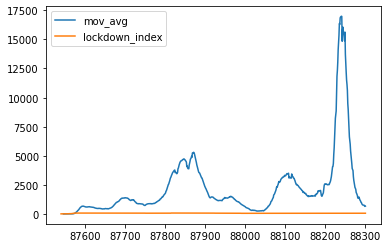

In [41]:
series = df_sub[['mov_avg', 'lockdown_index']]
series.plot()

Text(0, 0.5, 'mov_avg_work_mob')

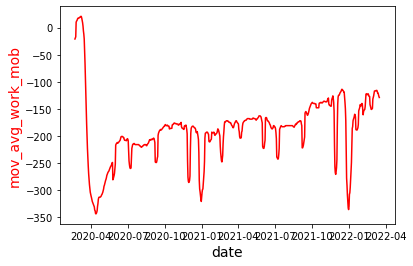

In [42]:
series = df_sub[['mov_avg_work_mob', 'lockdown_index', 'date']]
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(df_sub.date, df_sub.mov_avg_work_mob, color="red")
# set x-axis label
ax.set_xlabel("date",fontsize=14)
# set y-axis label
ax.set_ylabel("mov_avg_work_mob",color="red",fontsize=14)

In [43]:
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_sub.date, df_sub.lockdown_index,color="blue")
ax2.set_ylabel("lockdown_index",color="blue",fontsize=14)
plt.show()
fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

In [44]:
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_sub.date, df_sub.lockdown_index,color="blue")
ax2.set_ylabel("lockdown_index",color="blue",fontsize=14)
plt.show()
fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_sub.date, df_sub.mov_avg,color="blue")
ax2.set_ylabel("lockdown_index",color="blue",fontsize=14)
plt.show()
fig.savefig('cases_vs_workplace_mob.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

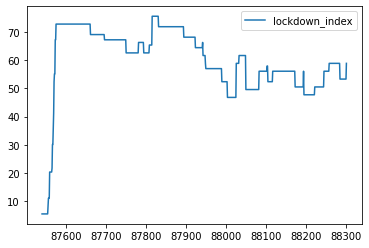

In [45]:
series = df_sub[['lockdown_index']]
series.plot()

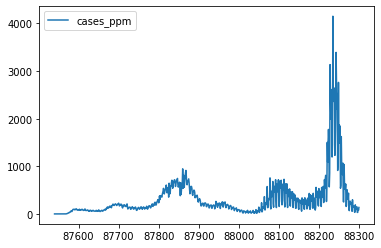

In [46]:
series = df_sub[['cases_ppm']]
series.plot()

In [47]:
df_sub

,deaths_ppm,cases_ppm,total_vaccinations,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,lockdown_index,date,mov_avg,mov_avg_work_mob,mov_avg_res_mob
87540,0.000000,0.000000,0.0,2.0,-1.0,5.56,2020-02-15,NaN,NaN,NaN
87541,0.000000,0.000000,0.0,0.0,-1.0,5.56,2020-02-16,NaN,NaN,NaN
87542,0.000000,0.000000,0.0,-24.0,5.0,5.56,2020-02-17,NaN,NaN,NaN
87543,0.000000,0.000000,0.0,0.0,1.0,5.56,2020-02-18,NaN,NaN,NaN
87544,0.000000,0.000000,0.0,1.0,0.0,5.56,2020-02-19,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
88296,1.279606,31.428436,254619167.0,-10.0,4.0,53.24,2022-03-12,745.682666,-121.0,34.0
88297,0.504633,32.518804,254667021.0,-9.0,2.0,53.24,2022-03-13,745.030848,-121.0,34.0
88298,-7.854856,104.362952,254713948.0,-24.0,6.0,53.24,2022-03-14,658.897770,-124.0,34.0
88299,3.847828,76.746300,254760201.0,-23.0,5.0,53.24,2022-03-15,646.245895,-127.0,34.0


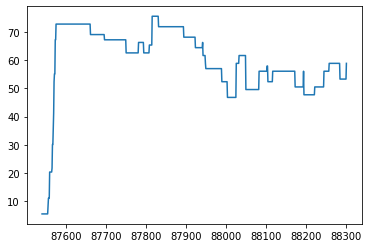

In [49]:
series = df_merged_US['lockdown_index']
series.plot()


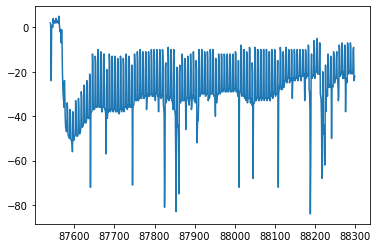

In [50]:
series = df_merged_US['workplaces_percent_change_from_baseline']
series.plot()

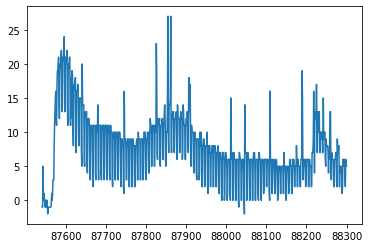

In [51]:
series = df_merged_US['residential_percent_change_from_baseline']
series.plot()

In [52]:
gc_res = sm.tsa.stattools.grangercausalitytests(df_merged_US[['residential_percent_change_from_baseline', 'workplaces_percent_change_from_baseline']],maxlag=10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.7872  , p=0.0031  , df_denom=757, df_num=1
ssr based chi2 test:   chi2=8.8220  , p=0.0030  , df=1
likelihood ratio test: chi2=8.7712  , p=0.0031  , df=1
parameter F test:         F=8.7872  , p=0.0031  , df_denom=757, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=34.5154 , p=0.0000  , df_denom=754, df_num=2
ssr based chi2 test:   chi2=69.4886 , p=0.0000  , df=2
likelihood ratio test: chi2=66.4894 , p=0.0000  , df=2
parameter F test:         F=34.5154 , p=0.0000  , df_denom=754, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.7235  , p=0.0000  , df_denom=751, df_num=3
ssr based chi2 test:   chi2=26.4144 , p=0.0000  , df=3
likelihood ratio test: chi2=25.9646 , p=0.0000  , df=3
parameter F test:         F=8.7235  , p=0.0000  , df_denom=751, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=15.7458 , p=0.0000  

In [53]:
gc_res = sm.tsa.stattools.grangercausalitytests(df_merged_US[['residential_percent_change_from_baseline', 'total_vaccinations']],maxlag=10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=25.7722 , p=0.0000  , df_denom=757, df_num=1
ssr based chi2 test:   chi2=25.8743 , p=0.0000  , df=1
likelihood ratio test: chi2=25.4436 , p=0.0000  , df=1
parameter F test:         F=25.7722 , p=0.0000  , df_denom=757, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=15.0299 , p=0.0000  , df_denom=754, df_num=2
ssr based chi2 test:   chi2=30.2592 , p=0.0000  , df=2
likelihood ratio test: chi2=29.6716 , p=0.0000  , df=2
parameter F test:         F=15.0299 , p=0.0000  , df_denom=754, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.4891  , p=0.0010  , df_denom=751, df_num=3
ssr based chi2 test:   chi2=16.6209 , p=0.0008  , df=3
likelihood ratio test: chi2=16.4413 , p=0.0009  , df=3
parameter F test:         F=5.4891  , p=0.0010  , df_denom=751, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.6416  , p=0.0010  

In [54]:
gc_res = sm.tsa.stattools.grangercausalitytests(df_merged_US[['residential_percent_change_from_baseline', 'lockdown_index']],maxlag=10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=63.6646 , p=0.0000  , df_denom=757, df_num=1
ssr based chi2 test:   chi2=63.9169 , p=0.0000  , df=1
likelihood ratio test: chi2=61.3709 , p=0.0000  , df=1
parameter F test:         F=63.6646 , p=0.0000  , df_denom=757, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=39.1457 , p=0.0000  , df_denom=754, df_num=2
ssr based chi2 test:   chi2=78.8106 , p=0.0000  , df=2
likelihood ratio test: chi2=74.9818 , p=0.0000  , df=2
parameter F test:         F=39.1457 , p=0.0000  , df_denom=754, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=14.9868 , p=0.0000  , df_denom=751, df_num=3
ssr based chi2 test:   chi2=45.3794 , p=0.0000  , df=3
likelihood ratio test: chi2=44.0729 , p=0.0000  , df=3
parameter F test:         F=14.9868 , p=0.0000  , df_denom=751, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=11.5713 , p=0.0000  

In [55]:
gc_res = sm.tsa.stattools.grangercausalitytests(df_merged_US[['residential_percent_change_from_baseline', 'deaths_ppm']],maxlag=10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0689  , p=0.7930  , df_denom=757, df_num=1
ssr based chi2 test:   chi2=0.0692  , p=0.7925  , df=1
likelihood ratio test: chi2=0.0692  , p=0.7925  , df=1
parameter F test:         F=0.0689  , p=0.7930  , df_denom=757, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3161  , p=0.7291  , df_denom=754, df_num=2
ssr based chi2 test:   chi2=0.6364  , p=0.7275  , df=2
likelihood ratio test: chi2=0.6361  , p=0.7276  , df=2
parameter F test:         F=0.3161  , p=0.7291  , df_denom=754, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.5544  , p=0.0141  , df_denom=751, df_num=3
ssr based chi2 test:   chi2=10.7626 , p=0.0131  , df=3
likelihood ratio test: chi2=10.6869 , p=0.0135  , df=3
parameter F test:         F=3.5544  , p=0.0141  , df_denom=751, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0480  , p=0.0166  

In [ ]:
df_merged_US.dtypes

### test-train-validation split


In [56]:
from sklearn.model_selection import train_test_split
def train_test_split_udf (df, frac):
    X_train, X_test = train_test_split(df, test_size=(frac), random_state=22)
    return X_train, X_test

In [57]:
df_train_1, df_test_1 = train_test_split_udf (df_merged, 0.2)
df_train_2, df_val_1 = train_test_split_udf (df_train_1, 0.125)

## Stationarity

In [58]:
df_sub.tail(5)

,deaths_ppm,cases_ppm,total_vaccinations,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,lockdown_index,date,mov_avg,mov_avg_work_mob,mov_avg_res_mob
88296,1.279606,31.428436,254619167.0,-10.0,4.0,53.24,2022-03-12,745.682666,-121.0,34.0
88297,0.504633,32.518804,254667021.0,-9.0,2.0,53.24,2022-03-13,745.030848,-121.0,34.0
88298,-7.854856,104.362952,254713948.0,-24.0,6.0,53.24,2022-03-14,658.897770,-124.0,34.0
88299,3.847828,76.746300,254760201.0,-23.0,5.0,53.24,2022-03-15,646.245895,-127.0,34.0
88300,5.836323,135.214664,254805930.0,-22.0,5.0,58.80,2022-03-16,669.209710,-129.0,33.0


In [59]:
train = df_sub[df_sub['date'] < pd.to_datetime("2021-12", format='%Y-%m')]
train['train'] = train['mov_avg_work_mob']
del train['date']
del train['mov_avg_work_mob']
test = df_sub[df_sub['date'] >= pd.to_datetime("2021-12", format='%Y-%m')]
del test['date']
test['test'] = test['mov_avg_work_mob']
del test['mov_avg_work_mob']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [60]:
test.shape

(106, 9)

In [61]:
train.shape

(655, 9)

In [62]:
df_sub.shape

(761, 10)

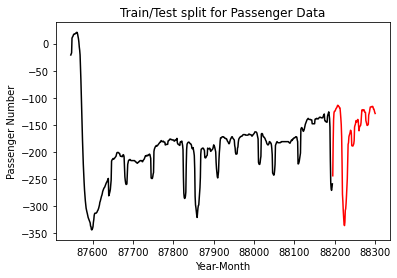

In [63]:
import seaborn as sns
plt.plot(train['train'], color = "black")
plt.plot(test['test'], color = "red")
plt.title("Train/Test split for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')
sns.set()
plt.show()

Text(0, 0.5, 'mov_avg_work_mob')

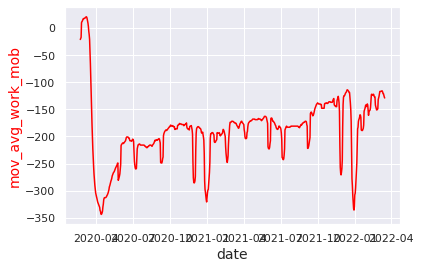

In [64]:
series = df_sub[['mov_avg_work_mob', 'lockdown_index', 'date']]
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(df_sub.date, df_sub.mov_avg_work_mob, color="red")
# set x-axis label
ax.set_xlabel("date",fontsize=14)
# set y-axis label
ax.set_ylabel("mov_avg_work_mob",color="red",fontsize=14)

In [66]:
import seaborn as sns
plt.plot(train['mov_'], color = "black")
# plt.plot(test['test'], color = "red")
# plt.title("Train/Test split for Passenger Data")
# plt.ylabel("Passenger Number")
# plt.xlabel('Year-Month')
# sns.set()
# plt.show()

KeyError: ignored

In [67]:
train = train.dropna()

In [68]:
from pmdarima.arima import auto_arima
model = auto_arima(train['train'], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train['train'])
forecast = model.predict(n_periods=len(test['test']))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

ModuleNotFoundError: ignored

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(test['test'],forecast))
print("RMSE: ", rms)

In [ ]:
forecast.head()

In [ ]:
test[['test']].head()

In [ ]:
import seaborn as sns
plt.plot(train['train'], color = "black")
plt.plot(forecast, color = "red")
plt.title("Train/Test split for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')
sns.set()
plt.show()

In [ ]:
forecast.plot()

In [ ]:
test['test'].plot()

In [ ]:
test = test.join(forecast)

In [ ]:
test.head()

In [ ]:
s = test[['test', 'Prediction']]
s.plot()

In [ ]:
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_sub.date, df_sub.lockdown_index,color="blue")
ax2.set_ylabel("lockdown_index",color="blue",fontsize=14)
plt.show()
fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_sub.date, df_sub.mov_avg,color="blue")
ax2.set_ylabel("lockdown_index",color="blue",fontsize=14)
plt.show()
fig.savefig('cases_vs_workplace_mob.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

Heatmaps with month and weekday

In [ ]:
df3["wday"] = df3.index.dayofweek
dict_days = {0:"1_Mon", 1:"2_Tue", 2:"3_Wed", 3:"4_Thu", 4:"5_Fri", 5:"6_Sat", 6:"7_Sun"}
df3["weekday"] = df3["wday"].apply(lambda x: dict_days[x])

In [69]:
df_merged_US.dtypes

country                                                       object
date                                                  datetime64[ns]
total_cases                                                  float64
total_deaths                                                 float64
population                                                   float64
new_vaccinations_smoothed                                    float64
new_people_vaccinated_smoothed                               float64
retail_and_recreation_percent_change_from_baseline           float64
grocery_and_pharmacy_percent_change_from_baseline            float64
parks_percent_change_from_baseline                           float64
transit_stations_percent_change_from_baseline                float64
workplaces_percent_change_from_baseline                      float64
residential_percent_change_from_baseline                     float64
lockdown_index                                               float64
weekday                           

In [36]:
df_merged_US_features = df_merged_US[['date', 'workplaces_percent_change_from_baseline',\
                                      'lockdown_index','cases_ppm','deaths_ppm','total_vaccinations']]

In [37]:
df4 = df_merged_US_features.copy()
df4.set_index("date", inplace=True)

In [38]:
ts_P = TimeSeries.from_series(df4["workplaces_percent_change_from_baseline"]) 

In [39]:
# create time series object for the feature columns
df_covF = df4.loc[:, df4.columns != "workplaces_percent_change_from_baseline"]
ts_covF = TimeSeries.from_dataframe(df_covF)

# check attributes of the time series
print("components (columns) of feature time series:", ts_covF.components)
print("duration:",ts_covF.duration)
print("frequency:",ts_covF.freq)
print("frequency:",ts_covF.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_covF.has_datetime_index)
print("deterministic:",ts_covF.is_deterministic)
print("univariate:",ts_covF.is_univariate)

components (columns) of feature time series: Index(['lockdown_index', 'cases_ppm', 'deaths_ppm', 'total_vaccinations'], dtype='object', name='component')
duration: 760 days 00:00:00
frequency: <Day>
frequency: D
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: False


In [40]:
ar_covF = ts_covF.all_values()
print(type(ar_covF))
ar_covF.shape

<class 'numpy.ndarray'>


(761, 4, 1)

In [41]:
df_covF = ts_covF.pd_dataframe()
type(df_covF)

pandas.core.frame.DataFrame

In [59]:
SPLIT = 716

In [60]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(SPLIT)
print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled price time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]


# train/test split and scaling of feature covariates
covF_train, covF_test = ts_covF.split_after(SPLIT)

scalerF = Scaler()
scalerF.fit_transform(covF_train)
covF_ttrain = scalerF.transform(covF_train) 
covF_ttest = scalerF.transform(covF_test)   
covF_t = scalerF.transform(ts_covF)  

# make sure data are of type float
covF_ttrain = ts_ttrain.astype(np.float32)
covF_ttest = ts_ttest.astype(np.float32)

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled feature covariates:")
covF_t.pd_dataframe().iloc[[0,-1]]


training start: 2020-02-15 00:00:00
training end: 2022-01-31 00:00:00
training duration: 716 days 00:00:00
test start: 2022-02-01 00:00:00
test end: 2022-03-16 00:00:00
test duration: 43 days 00:00:00
first and last row of scaled price time series:
first and last row of scaled feature covariates:


component,lockdown_index,cases_ppm,deaths_ppm,total_vaccinations
date,,,,
2020-02-15,0.00,0.00,0.00,0.00
2022-03-16,0.76,0.03,0.44,1.02


In [61]:
ts_P.time_index

DatetimeIndex(['2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18',
               '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
               '2020-02-23', '2020-02-24',
               ...
               '2022-03-07', '2022-03-08', '2022-03-09', '2022-03-10',
               '2022-03-11', '2022-03-12', '2022-03-13', '2022-03-14',
               '2022-03-15', '2022-03-16'],
              dtype='datetime64[ns]', name='date', length=761, freq='D')

In [63]:
# feature engineering - create time covariates: hour, weekday, month, year, country-specific holidays
covT = datetime_attribute_timeseries(  ts_P.time_index, 
                                        attribute="day", 
                                        until=pd.Timestamp("2022-04-01"), one_hot=False)
covT = covT.stack(datetime_attribute_timeseries(covT.time_index, attribute="day_of_week", one_hot=False))
covT = covT.stack(datetime_attribute_timeseries(covT.time_index, attribute="month", one_hot=False))
covT = covT.stack(datetime_attribute_timeseries(covT.time_index, attribute="year", one_hot=False))

covT = covT.add_holidays(country_code="US")
covT = covT.astype(np.float32)


# train/test split
covT_train, covT_test = covT.split_after(SPLIT)


# rescale the covariates: fitting on the training set
scalerT = Scaler()
scalerT.fit(covT_train)
covT_ttrain = scalerT.transform(covT_train)
covT_ttest = scalerT.transform(covT_test)
covT_t = scalerT.transform(covT)

covT_t = covT_t.astype(np.float32)


pd.options.display.float_format = '{:.0f}'.format
print("first and last row of unscaled time covariates:")
covT.pd_dataframe().iloc[[0,-1]]

first and last row of unscaled time covariates:


component,day,day_of_week,month,year,holidays
time,,,,,
2020-02-15,15,5,2,2020,0
2022-04-01,1,4,4,2022,0


In [69]:
LOAD = False         # True = load previously saved model from disk?  False = (re)train the model
SAVE = "\_TForm_model10e.pth.tar"   # file name to save the model under

EPOCHS = 200
INLEN = 10          # input size
FEAT = 32           # d_model = number of expected features in the inputs, up to 512    
HEADS = 4           # default 8
ENCODE = 4          # encoder layers
DECODE = 4          # decoder layers
DIM_FF = 128        # dimensions of the feedforward network, default 2048
BATCH = 32          # batch size
ACTF = "relu"       # activation function, relu (default) or gelu
SCHLEARN = None     # a PyTorch learning rate scheduler; None = constant rate
LEARN = 1e-3        # learning rate
VALWAIT = 1         # epochs to wait before evaluating the loss on the test/validation set
DROPOUT = 0.1       # dropout rate
N_FC = 1            # output size

RAND = 42           # random seed
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = 3          # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]


FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

mpath = os.path.abspath(os.getcwd()) + SAVE     # path and file name to save the model

In [70]:
model = TransformerModel(
                    input_chunk_length = INLEN,
                    output_chunk_length = N_FC,
                    batch_size = BATCH,
                    n_epochs = EPOCHS,
                    model_name = "Transformer_price",
                    nr_epochs_val_period = VALWAIT,
                    d_model = FEAT,
                    nhead = HEADS,
                    num_encoder_layers = ENCODE,
                    num_decoder_layers = DECODE,
                    dim_feedforward = DIM_FF,
                    dropout = DROPOUT,
                    activation = ACTF,
                    random_state=RAND,
                    likelihood=QuantileRegression(quantiles=QUANTILES), 
                    optimizer_kwargs={'lr': LEARN},
                    add_encoders={"cyclic": {"future": ["day", "dayofweek", "month"]}},
                    save_checkpoints=True,
                    force_reset=True
                    )

In [72]:
if LOAD:
    print("have loaded a previously saved model from disk:" + mpath)
    model = TransformerModel.load_model(mpath)                            # load previously model from disk 
else:
    model.fit(  ts_ttrain, 
                past_covariates=covT_t, 
                verbose=True)
    print("have saved the model after training:", mpath)
    model.save_model(mpath)

Training: 0it [00:00, ?it/s]

have saved the model after training: /content\_TForm_model10e.pth.tar


In [73]:
# testing: generate predictions
ts_tpred = model.predict(   n=len(ts_ttest), 
                            num_samples=N_SAMPLES,   
                            n_jobs=N_JOBS, 
                            verbose=True)

Predicting: 23it [00:00, ?it/s]

In [74]:

# retrieve forecast series for chosen quantiles, 
# inverse-transform each series,
# insert them as columns in a new dataframe dfY
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None
pd.options.display.float_format = '{:,.2f}'.format
dfY = pd.DataFrame()
dfY["Actual"] = TimeSeries.pd_series(ts_test)


# helper function: get forecast values for selected quantile q and insert them in dataframe dfY
def predQ(ts_t, q):
    ts_tq = ts_t.quantile_timeseries(q)
    ts_q = scalerP.inverse_transform(ts_tq)
    s = TimeSeries.pd_series(ts_q)
    header = "Q" + format(int(q*100), "02d")
    dfY[header] = s
    if q==0.5:
        ts_q50 = ts_q
        q50_RMSE = rmse(ts_q50, ts_test)
        q50_MAPE = mape(ts_q50, ts_test) 
        print("RMSE:", f'{q50_RMSE:.2f}')
        print("MAPE:", f'{q50_MAPE:.2f}')
  
    
# call helper function predQ, once for every quantile
_ = [predQ(ts_tpred, q) for q in QUANTILES]

# move Q50 column to the left of the Actual column
col = dfY.pop("Q50")
dfY.insert(1, col.name, col)
dfY.iloc[np.r_[0:2, -2:0]]

RMSE: 3.84
MAPE: 15.25


,Actual,Q50,Q01,Q10,Q20,Q80,Q90,Q99
date,,,,,,,,
2022-02-01,-23.00,-22.26,-34.39,-24.05,-23.37,-21.47,-19.72,-17.11
2022-02-02,-26.00,-21.50,-33.80,-23.77,-22.99,-20.68,-19.52,-16.51
2022-03-15,-23.00,-23.79,-31.52,-25.86,-24.96,-22.49,-21.84,-17.98
2022-03-16,-22.00,-22.21,-32.96,-24.49,-23.88,-20.82,-19.26,-16.78


In [82]:
# retrieve forecast series for chosen quantiles, 
# inverse-transform each series,
# insert them as columns in a new dataframe dfY
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None
pd.options.display.float_format = '{:,.2f}'.format
dfY = pd.DataFrame()
dfY["Actual"] = TimeSeries.pd_series(ts_test)


# helper function: get forecast values for selected quantile q and insert them in dataframe dfY
def predQ(ts_t, q):
    ts_tq = ts_t.quantile_timeseries(q)
    ts_q = scalerP.inverse_transform(ts_tq)
    s = TimeSeries.pd_series(ts_q)
    header = "Q" + format(int(q*100), "02d")
    dfY[header] = s
    if q==0.5:
        ts_q50 = ts_q
        q50_RMSE = rmse(ts_q50, ts_test)
        q50_MAPE = mape(ts_q50, ts_test) 
        print("RMSE:", f'{q50_RMSE:.2f}')
        print("MAPE:", f'{q50_MAPE:.2f}')
  
    
# call helper function predQ, once for every quantile
_ = [predQ(ts_tpred, q) for q in QUANTILES]

# move Q50 column to the left of the Actual column
col = dfY.pop("Q50")
dfY.insert(1, col.name, col)
dfY.iloc[np.r_[0:2, -2:0]]

RMSE: 3.84
MAPE: 15.25


,Actual,Q50,Q01,Q10,Q20,Q80,Q90,Q99
date,,,,,,,,
2022-02-01,-23.00,-22.26,-34.39,-24.05,-23.37,-21.47,-19.72,-17.11
2022-02-02,-26.00,-21.50,-33.80,-23.77,-22.99,-20.68,-19.52,-16.51
2022-03-15,-23.00,-23.79,-31.52,-25.86,-24.96,-22.49,-21.84,-17.98
2022-03-16,-22.00,-22.21,-32.96,-24.49,-23.88,-20.82,-19.26,-16.78


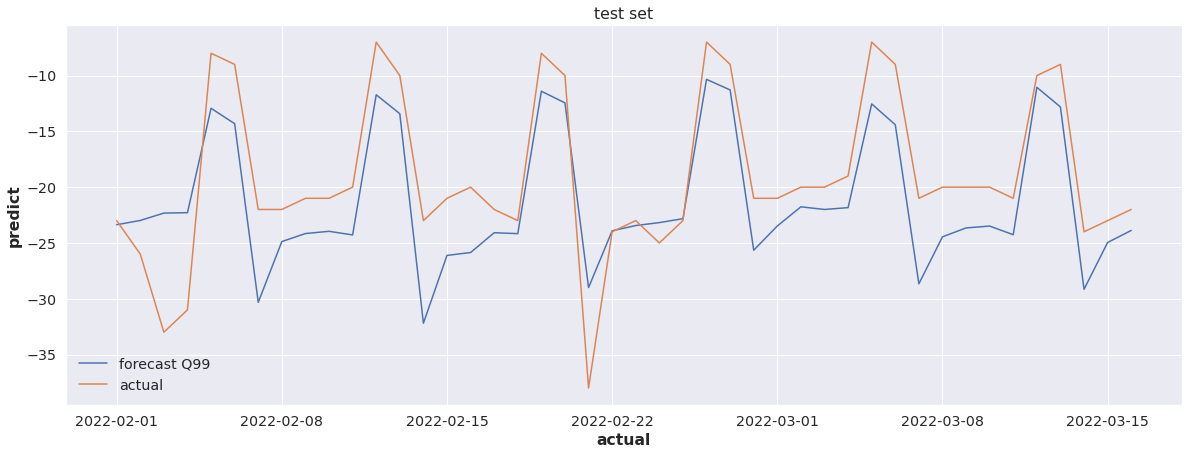

In [80]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
sns.set(font_scale=1.3)
p = sns.lineplot(x = "date", y = "Q20", data = dfY, palette="coolwarm")
sns.lineplot(x = "date", y = "Actual", data = dfY, palette="coolwarm")
plt.legend(labels=["forecast Q99", "actual"])
p.set_ylabel("predict")
p.set_xlabel("actual")
p.set_title("test set");